In [1]:
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np

In [2]:
import mdtraj as md


In [3]:
import pyemma.coordinates as coor
import pyemma.msm as msm
import pyemma.plots as mplt
import pickle
import seaborn as sns

In [4]:
# This file is part of PyEMMA.
#
# Copyright (c) 2014-2016 Computational Molecular Biology Group, Freie Universitaet Berlin (GER)
#
# PyEMMA is free software: you can redistribute it and/or modify
# it under the terms of the GNU Lesser General Public License as published by
# the Free Software Foundation, either version 3 of the License, or
# (at your option) any later version.
#
# This program is distributed in the hope that it will be useful,
# but WITHOUT ANY WARRANTY; without even the implied warranty of
# MERCHANTABILITY or FITNESS FOR A PARTICULAR PURPOSE.  See the
# GNU General Public License for more details.
#
# You should have received a copy of the GNU Lesser General Public License
# along with this program.  If not, see <http://www.gnu.org/licenses/>.


from __future__ import absolute_import
import numpy as _np
import warnings
from pyemma.util import types as _types

from math import sqrt as _sqrt
import logging

logger = logging.getLogger(__name__)


__author__ = 'noe, marscher'
__all__ = ['plot_flux', 'plot_network', 'plot_markov_model', 'NetworkPlot']


class NetworkPlot(object):
    r"""Plot of network with nodes and arcs """

    def __init__(self, A, pos=None, xpos=None, ypos=None, ax=None):
        r"""

        Parameters
        ----------
        A : ndarray(n,n)
            weight matrix or adjacency matrix of the network to visualize
        pos : ndarray(n,2)
            user-defined positions
        xpos : ndarray(n,)
            user-defined x-positions
        ypos : ndarray(n,)
            user-defined y-positions
        ax : matplotlib Axes object, optional, default=None
            The axes to plot to. When set to None a new Axes (and Figure) object will be used.

        Examples
        --------
        We define first define a reactive flux by taking the following transition
        matrix and computing TPT from state 2 to 3.

        >>> import numpy as np
        >>> P = np.array([[0.8,  0.15, 0.05,  0.0,  0.0],
        ...               [0.1,  0.75, 0.05, 0.05, 0.05],
        ...               [0.05,  0.1,  0.8,  0.0,  0.05],
        ...               [0.0,  0.2, 0.0,  0.8,  0.0],
        ...               [0.0,  0.02, 0.02, 0.0,  0.96]])
        >>> from pyemma import msm
        >>> F = msm.tpt(msm.markov_model(P), [2], [3])

        now plot the gross flux
        >>> NetworkPlot(F.gross_flux).plot_network() # doctest:+ELLIPSIS
        <matplotlib.figure.Figure...

        """

        if A.shape[0] >= 50:
            warnings.warn("The layout optimization method will take a long"
                          " time for large networks! It is recommended to"
                          " coarse grain your model first!")
        self.A = A
        if pos is not None and len(pos) < len(A):
            raise ValueError(
                'Given less positions (%i) than states (%i)' % (len(pos), len(A)))
        if xpos is not None and len(xpos) < len(A):
            raise ValueError(
                'Given less positions (%i) than states (%i)' % (len(xpos), len(A)))
        if ypos is not None and len(ypos) < len(A):
            raise ValueError(
                'Given less positions (%i) than states (%i)' % (len(ypos), len(A)))
        self.pos = pos
        self.xpos = xpos
        self.ypos = ypos
        self.ax = ax

    def _draw_arrow(
        self, x1, y1, x2, y2, Dx, Dy, label="", width=1.0, arrow_curvature=1.0, color="black",
        patchA=None, patchB=None, shrinkA=0, shrinkB=0, arrow_label_size=None):
        """
        Draws a slightly curved arrow from (x1,y1) to (x2,y2).
        Will allow the given patches at start end end.

        """
        # set arrow properties
        dist = _sqrt(
            ((x2 - x1) / float(Dx))**2 + ((y2 - y1) / float(Dy))**2)
        arrow_curvature *= 0.075  # standard scale
        rad = arrow_curvature / (dist)
        tail_width = width
        head_width = max(0.5, 2 * width)
        head_length = head_width
        self.ax.annotate(
            "", xy=(x2, y2), xycoords='data', xytext=(x1, y1), textcoords='data',
            arrowprops=dict(
                arrowstyle='simple,head_length=%f,head_width=%f,tail_width=%f' % (
                    head_length, head_width, tail_width),
                color=color, shrinkA=shrinkA, shrinkB=shrinkB, patchA=patchA, patchB=patchB,
                connectionstyle="arc3,rad=%f" % -rad),
            zorder=1)
        # weighted center position
        center = _np.array([0.55 * x1 + 0.45 * x2, 0.55 * y1 + 0.45 * y2])
        v = _np.array([x2 - x1, y2 - y1])  # 1->2 vector
        vabs = _np.abs(v)
        vnorm = _np.array([v[1], -v[0]])  # orthogonal vector
        vnorm = _np.divide(vnorm, _np.linalg.norm(vnorm))  # normalize
        # cross product to determine the direction into which vnorm points
        z = _np.cross(v, vnorm)
        if z < 0:
            vnorm *= -1
        offset = 0.5 * arrow_curvature * \
            ((vabs[0] / (vabs[0] + vabs[1]))
             * Dx + (vabs[1] / (vabs[0] + vabs[1])) * Dy)
        ptext = center + offset * vnorm
        t = self.ax.text(
            ptext[0], ptext[1], label, size=arrow_label_size,
            horizontalalignment='center', verticalalignment='center', zorder=2, color='black')
        t.set_bbox(dict(facecolor='white', alpha=1, edgecolor='white'))
        
        
    def plot_network(
        self, state_sizes=None, state_scale=1.0, state_colors='#ff5500', state_labels='auto',
        arrow_scale=1.0, arrow_curvature=1.0, arrow_labels='weights', arrow_label_format='%10.2f',
        max_width=12, max_height=12, figpadding=0.2, xticks=False, yticks=False, show_frame=False,
        **textkwargs):
        """
        Draws a network using discs and curved arrows.

        The thicknesses and labels of the arrows are taken from the off-diagonal matrix elements
        in A.

        """

        # Set the default values for the text dictionary
        from matplotlib import pyplot as _plt
        textkwargs.setdefault('size', None)
        textkwargs.setdefault('horizontalalignment', 'center')
        textkwargs.setdefault('verticalalignment', 'center')
        textkwargs.setdefault('color', 'black')
        # remove the temporary key 'arrow_label_size' as it cannot be parsed by plt.text!
        arrow_label_size = textkwargs.pop('arrow_label_size', textkwargs['size'])
        if self.pos is None:
            self.layout_automatic()
        # number of nodes
        n = len(self.pos)
        # get bounds and pad figure
        xmin = _np.min(self.pos[:, 0])
        xmax = _np.max(self.pos[:, 0])
        Dx = xmax - xmin
        xmin -= Dx * figpadding
        xmax += Dx * figpadding
        Dx *= 1 + figpadding
        ymin = _np.min(self.pos[:, 1])
        ymax = _np.max(self.pos[:, 1])
        Dy = ymax - ymin
        ymin -= Dy * figpadding
        ymax += Dy * figpadding
        Dy *= 1 + figpadding
        # sizes of nodes
        if state_sizes is None:
            state_sizes = 0.5 * state_scale * \
                min(Dx, Dy)**2 * _np.ones(n) / float(n)
        else:
            state_sizes = 0.5 * state_scale * \
                min(Dx, Dy)**2 * state_sizes / (_np.max(state_sizes) * float(n))
        # automatic arrow rescaling
        arrow_scale *= 1.0 / \
            (_np.max(self.A - _np.diag(_np.diag(self.A))) * _sqrt(n))
        # size figure
        if (Dx / max_width > Dy / max_height):
            figsize = (max_width, Dy * (max_width / Dx))
        else:
            figsize = (Dx / Dy * max_height, max_height)
        if self.ax is None:
            logger.debug("creating new figure")
            fig = _plt.figure(None, figsize=figsize)
            self.ax = fig.add_subplot(111)
        else:
            fig = self.ax.figure
            window_extend = self.ax.get_window_extent()
            axes_ratio = window_extend.height / window_extend.width
            data_ratio = (ymax - ymin) / (xmax - xmin)
            q = axes_ratio / data_ratio
            if q > 1.0:
                ymin *= q
                ymax *= q
            else:
                xmin /= q
                xmax /= q
        if not xticks:
            self.ax.get_xaxis().set_ticks([])
        if not yticks:
            self.ax.get_yaxis().set_ticks([])
        # show or suppress frame
        self.ax.set_frame_on(show_frame)
        # set node labels
        if isinstance(state_labels, str) and state_labels == 'auto':
            state_labels = [str(i) for i in _np.arange(n)]
        else:
            if len(state_labels) != n:
                raise ValueError("length of state_labels({}) has to match length of states({})."
                                 .format(len(state_labels), n))
        # set node colors
        if state_colors is None:
            state_colors = '#ff5500'  # None is not acceptable
        if isinstance(state_colors, str):
            state_colors = [state_colors] * n
        if isinstance(state_colors, list) and not len(state_colors) == n:
            raise ValueError("Mistmatch between nstates and nr. state_colors (%u vs %u)" % (n, len(state_colors)))
        try:
            colorscales = _types.ensure_ndarray(state_colors, ndim=1, kind='numeric')
            colorscales /= colorscales.max()
            state_colors = [_plt.cm.binary(int(256.0 * colorscales[i])) for i in range(n)]
        except AssertionError:
            # assume we have a list of strings now.
            logger.debug("could not cast 'state_colors' to numeric values.")

        # set arrow labels
        if isinstance(arrow_labels, _np.ndarray):
            L = arrow_labels
            if isinstance(arrow_labels[0,0], str):
                arrow_label_format = '%s'
        elif isinstance(arrow_labels, str) and arrow_labels.lower() == 'weights':
            L = self.A[:, :]
        elif arrow_labels is None:
            L = _np.empty(_np.shape(self.A), dtype=object)
            L[:, :] = ''
            arrow_label_format = '%s'
        else:
            raise ValueError('invalid arrow labels')

        # draw circles
        circles = []
        for i in range(n):
            # choose color
            c = _plt.Circle(
                self.pos[i], radius=_sqrt(
                    0.5 * state_sizes[i]) / 2.0,
                color=state_colors[i], zorder=2)
            circles.append(c)
            self.ax.add_artist(c)
            # add annotation
            self.ax.text(
                self.pos[i][0], self.pos[i][1], state_labels[i], zorder=3, **textkwargs)

        assert len(circles) == n, "%i != %i" % (len(circles), n)

        # draw arrows
        for i in range(n):
            for j in range(i + 1, n):
                if (abs(self.A[i, j]) > 0):
                    self._draw_arrow(
                        self.pos[i, 0], self.pos[i, 1], self.pos[j, 0], self.pos[j, 1], Dx, Dy,
                        label=arrow_label_format%L[i, j], width=arrow_scale * self.A[i, j],
                        arrow_curvature=arrow_curvature, patchA=circles[i], patchB=circles[j],
                        shrinkA=3, shrinkB=0, arrow_label_size=arrow_label_size)
                if (abs(self.A[j, i]) > 0):
                    self._draw_arrow(
                        self.pos[j, 0], self.pos[j, 1], self.pos[i, 0], self.pos[i, 1], Dx, Dy,
                        label=arrow_label_format%L[j, i], width=arrow_scale * self.A[j, i],
                        arrow_curvature=arrow_curvature, patchA=circles[j], patchB=circles[i],
                        shrinkA=3, shrinkB=0, arrow_label_size=arrow_label_size)

        # plot
        self.ax.set_xlim(xmin, xmax)
        self.ax.set_ylim(ymin, ymax)
        return fig

    def _find_best_positions(self, G):
        """Finds best positions for the given graph (given as adjacency matrix)
        nodes by minimizing a network potential.
        """
        initpos = None
        holddim = None
        if self.xpos is not None:
            y = _np.random.random(len(self.xpos))
            initpos = _np.vstack((self.xpos, y)).T
            holddim = 0
        elif self.ypos is not None:
            x = _np.zeros_like(self.xpos)
            initpos = _np.vstack((x, self.ypos)).T
            holddim = 1
        # nothing to do
        elif self.xpos is not None and self.ypos is not None:
            return _np.array([self.xpos, self.ypos]), 0
        from pyemma.plots._ext.fruchterman_reingold import _fruchterman_reingold
        best_pos = _fruchterman_reingold(G, pos=initpos, dim=2, hold_dim=holddim)

        # rescale fixed to user settings and balance the other coordinate
        if self.xpos is not None:
            # rescale x to fixed value
            best_pos[:, 0] *= (_np.max(self.xpos) - _np.min(self.xpos)
                               ) / (_np.max(best_pos[:, 0]) - _np.min(best_pos[:, 0]))
            best_pos[:, 0] += _np.min(self.xpos) - _np.min(best_pos[:, 0])
            # rescale y to balance
            if _np.max(best_pos[:, 1]) - _np.min(best_pos[:, 1]) > 0.01:
                best_pos[:, 1] *= (_np.max(self.xpos) - _np.min(self.xpos)
                                   ) / (_np.max(best_pos[:, 1]) - _np.min(best_pos[:, 1]))
        if self.ypos is not None:
            best_pos[:, 1] *= (_np.max(self.ypos) - _np.min(self.ypos)
                               ) / (_np.max(best_pos[:, 1]) - _np.min(best_pos[:, 1]))
            best_pos[:, 1] += _np.min(self.ypos) - _np.min(best_pos[:, 1])
            # rescale x to balance
            if _np.max(best_pos[:, 0]) - _np.min(best_pos[:, 0]) > 0.01:
                best_pos[:, 0] *= (_np.max(self.ypos) - _np.min(self.ypos)
                                   ) / (_np.max(best_pos[:, 0]) - _np.min(best_pos[:, 0]))

        return best_pos

    def layout_automatic(self):
        n = len(self.A)
        I, J = _np.where(self.A > 0.0)
        # note: against intuition this has to be of type float
        A = _np.zeros((n, n))
        A[I, J] = 1

        self.pos = self._find_best_positions(A)


def plot_markov_model(
    P, pos=None, state_sizes=None, state_scale=1.0, state_colors='#ff5500', state_labels='auto',
    minflux=1e-6, arrow_scale=1.0, arrow_curvature=1.0, arrow_labels='weights',
    arrow_label_format='%2.e', max_width=12, max_height=12, figpadding=0.2, show_frame=False,
    ax=None, **textkwargs):
    r"""Network representation of MSM transition matrix

    This visualization is not optimized for large matrices. It is meant to be
    used for the visualization of small models with up to 10-20 states, e.g.
    obtained by a HMM coarse-graining. If used with large network, the automatic
    node positioning will be very slow and may still look ugly.

    Parameters
    ----------
    P : ndarray(n,n) or MSM object with attribute 'transition matrix'
        Transition matrix or MSM object
    pos : ndarray(n,2), optional, default=None
        User-defined positions to draw the states on. If not given, will try
        to place them automatically.
    state_sizes : ndarray(n), optional, default=None
        User-defined areas of the discs drawn for each state. If not given,
        the stationary probability of P will be used.
    state_colors : string, ndarray(n), or list, optional, default='#ff5500' (orange)
        string :
            a Hex code for a single color used for all states
        array :
            n values in [0,1] which will result in a grayscale plot
        list :
            of len = nstates, with a color for each state. The list can mix strings, RGB values and
            hex codes, e.g. :py:obj:`state_colors` = ['g', 'red', [.23, .34, .35], '#ff5500'] is
            possible.
    state_labels : list of strings, optional, default is 'auto'
        A list with a label for each state, to be displayed at the center
        of each node/state. If left to 'auto', the labels are automatically set to the state
        indices.
    minflux : float, optional, default=1e-6
        The minimal flux (p_i * p_ij) for a transition to be drawn
    arrow_scale : float, optional, default=1.0
        Relative arrow scale. Set to a value different from 1 to increase
        or decrease the arrow width.
    arrow_curvature : float, optional, default=1.0
        Relative arrow curvature. Set to a value different from 1 to make
        arrows more or less curved.
    arrow_labels : 'weights', None or a ndarray(n,n) with label strings. Optional, default='weights'
        Strings to be placed upon arrows. If None, no labels will be used.
        If 'weights', the elements of P will be used. If a matrix of strings is
        given by the user these will be used.
    arrow_label_format : str, optional, default='%10.2f'
        The numeric format to print the arrow labels
    max_width = 12
        The maximum figure width
    max_height = 12
        The maximum figure height
    figpadding = 0.2
        The relative figure size used for the padding
    show_frame: boolean (default=False)
        Draw a frame around the network.
    ax : matplotlib Axes object, optional, default=None
        The axes to plot to. When set to None a new Axes (and Figure) object will be used.
    textkwargs : optional argument for the text of the state and arrow labels.
        See http://matplotlib.org/api/text_api.html#matplotlib.text.Text for more info. The
        parameter 'size' refers to the size of the state and arrow labels and overwrites the
        matplotlib default. The parameter 'arrow_label_size' is only used for the arrow labels;
        please note that 'arrow_label_size' is not part of matplotlib.text.Text's set of parameters
        and will raise an exception when passed to matplotlib.text.Text directly.

    Returns
    -------
    fig, pos : matplotlib.Figure, ndarray(n,2)
    a Figure object containing the plot and the positions of states.
    Can be used later to plot a different network representation (e.g. the flux)

    Examples
    --------
    >>> import numpy as np
    >>> P = np.array([[0.8,  0.15, 0.05,  0.0,  0.0],
    ...              [0.1,  0.75, 0.05, 0.05, 0.05],
    ...              [0.05,  0.1,  0.8,  0.0,  0.05],
    ...              [0.0,  0.2, 0.0,  0.8,  0.0],
    ...              [0.0,  0.02, 0.02, 0.0,  0.96]])
    >>> plot_markov_model(P) # doctest:+ELLIPSIS
    (<matplotlib.figure.Figure..., array...)

    """
    from msmtools import analysis as msmana
    if isinstance(P, _np.ndarray):
        P = P.copy()
    else:
        # MSM object? then get transition matrix first
        P = P.transition_matrix.copy()
    if state_sizes is None:
        state_sizes = msmana.stationary_distribution(P)
    if minflux > 0:
        F = _np.dot(_np.diag(msmana.stationary_distribution(P)), P)
        I, J = _np.where(F < minflux)
        P[I, J] = 0.0
    plot = NetworkPlot(P, pos=pos, ax=ax)
    fig = plot.plot_network(
        state_sizes=state_sizes, state_scale=state_scale, state_colors=state_colors,
        state_labels=state_labels, arrow_scale=arrow_scale, arrow_curvature=arrow_curvature,
        arrow_labels=arrow_labels, arrow_label_format=arrow_label_format, max_width=max_width,
        max_height=max_height, figpadding=figpadding, xticks=False, yticks=False,
        show_frame=show_frame, **textkwargs)
    return fig, plot.pos




## Import data

In [5]:
indir = './Data/Chodera_data/Selection/'
topfile =  indir+'/a1e-solute.pdb'
from glob import glob
selection_nc = glob(indir+'/*.nc')
print(len(selection_nc))

500


In [6]:
timestep = 0.1

## Create observed MSM

In [7]:
feat = coor.featurizer(topfile)
feat.add_backbone_torsions(cossin=False)


In [8]:
inp = coor.source(selection_nc, feat)
print('number of trajectories = ',inp.number_of_trajectories())
print('trajectory length = ',inp.trajectory_length(0))
print('number of dimension = ',inp.dimension())

A Jupyter Widget

number of trajectories =  500
trajectory length =  1000
number of dimension =  2


In [9]:
inp.describe()

['Feature reader with following features', 'PHI 0 ALA 2', 'PSI 0 ALA 2']

In [10]:
n_clusters=500
clustering = coor.cluster_kmeans(inp,k=n_clusters, max_iter=500)


A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

14-02-18 09:44:03 pyemma.coordinates.clustering.kmeans.KmeansClustering[0] INFO     Cluster centers converged after 2 steps.


In [11]:
dtrajs = clustering.dtrajs


A Jupyter Widget

In [12]:
its = msm.timescales_msm(dtrajs, lags=np.arange(20), nits=10, n_jobs=-1)


14-02-18 09:44:09 pyemma.msm.estimators.maximum_likelihood_msm.MaximumLikelihoodMSM[1] WARNING  Ignored error during estimation: row, column, and data array must all be the same length


A Jupyter Widget

14-02-18 09:44:47 pyemma.msm.estimators.implied_timescales.ImpliedTimescales[2] WARNING  Estimation has failed at lagtimes: [0]. Run single-lag estimation at these lags to track down the error.
14-02-18 09:44:49 pyemma.msm.estimators.implied_timescales.ImpliedTimescales[2] WARNING  Some timescales could not be computed. Timescales array is smaller than expected or contains NaNs


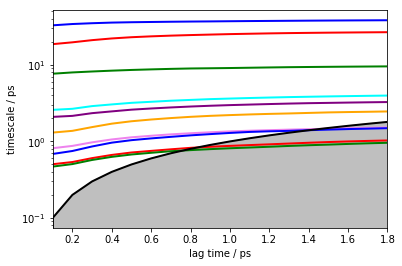

In [13]:
mplt.plot_implied_timescales(its, ylog=True, dt=0.1, units='ps', linewidth=2)


In [14]:
ftrajs = inp.get_output()

A Jupyter Widget

In [15]:
fxx = np.concatenate(ftrajs)

In [16]:
msm_lag = 10
M = msm.estimate_markov_model(dtrajs, msm_lag)
len(M.active_set)

500

## Free Energy Plot

In [175]:
def plot_free_energy(xall, yall, weights=None, ax=None, nbins=100, ncountours=100, offset=-1,
                     avoid_zero_count=True, minener_zero=True, kT=1.0, vmin=0.0, vmax=None,
                     cmap='spectral', cbar=True, cbar_label='Free energy (kJ/mol)', hist_range=None, 
                     ticker=None, alpha=1.0, linewidths=2):
    
    import matplotlib.pylab as _plt
    import warnings
#     cmap = _get_cmap(cmap)
    # check input
    if offset != -1:
        warnings.warn("Parameter offset is deprecated and will be ignored", DeprecationWarning)
    # histogram
    
    z, xedge, yedge = np.histogram2d(xall, yall, bins=nbins, weights=weights, range=hist_range)
    x = 0.5*(xedge[:-1] + xedge[1:])
    y = 0.5*(yedge[:-1] + yedge[1:])
    # avoid zeros
    if avoid_zero_count:
        zmin_nonzero = np.min(z[np.where(z > 0)])
        z = np.maximum(z, zmin_nonzero)
    # compute free energies
    F = -kT * np.log(z)
    if minener_zero:
        F -= np.min(F)
    # do a contour plot
    extent = [yedge[0], yedge[-1], xedge[0], xedge[-1]]

    if ax is None:
        ax = plt.gca()
    CS = ax.contourf(x, y, F.T, ncountours, extent=extent, cmap=cmap, vmin=vmin, vmax=vmax, alpha=alpha, zorder=0)
    ax.contour(x, y, F.T, ncountours, extent=extent, cmap=cmap, vmin=vmin, vmax=vmax, alpha=1, 
               linewidths=linewidths, zorder=1)


    if cbar:
        cbar = plt.colorbar(CS,fraction=0.04)
        if cbar_label is not None:
            cbar.ax.set_ylabel(cbar_label)
        cbar.locator=ticker
        cbar.update_ticks()
    return plt.gcf(), ax

In [18]:
import msmexplorer as msme

/Users/robert_arbon/anaconda/envs/sonification/lib/python3.5/site-packages/seaborn/apionly.py:6: UserWarning: As seaborn no longer sets a default style on import, the seaborn.apionly module is deprecated. It will be removed in a future version.
  warnings.warn(msg, UserWarning)


In [102]:
T = 302
k = 0.0083144621
units = 180/np.pi
   
hist_range=[[-181,181],[-181,181]]

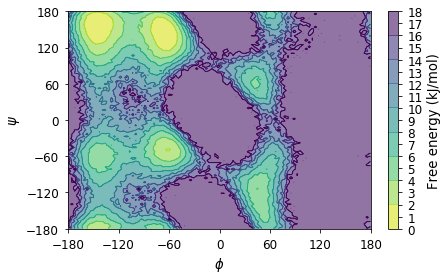

In [173]:
from matplotlib.ticker import MultipleLocator
with sns.plotting_context('paper', font_scale=1.5):

    
    fig, ax = plot_free_energy(fxx[:,0]*units, fxx[:,1]*units, cmap='viridis_r', 
                               ncountours=10, hist_range=hist_range, vmax=None,kT=k*T, 
                               minener_zero=True, ticker=MultipleLocator(base=1), alpha=0.6, linewidths=1)
    plt.ylabel(r'$\psi$')
    plt.xlabel(r'$\phi$')
    plt.xlim((-180,180))
    plt.ylim((-180,180))

    plt.gca().yaxis.set_major_locator(MultipleLocator(base=60,))
    plt.gca().xaxis.set_major_locator(MultipleLocator(base=60,))
#     plt.savefig('figures/free_energy_2d.png', transparent=True, bbox_inches='tight')



## Create HMM

In [68]:
n_sets = 4
HMM = M.coarse_grain(n_sets)
distibution = HMM.metastable_distributions
membership = HMM.metastable_memberships 
assignment = HMM.metastable_assignments

In [69]:
HMM.stationary_distribution

array([ 0.00176447,  0.00360242,  0.11352581,  0.8811073 ])

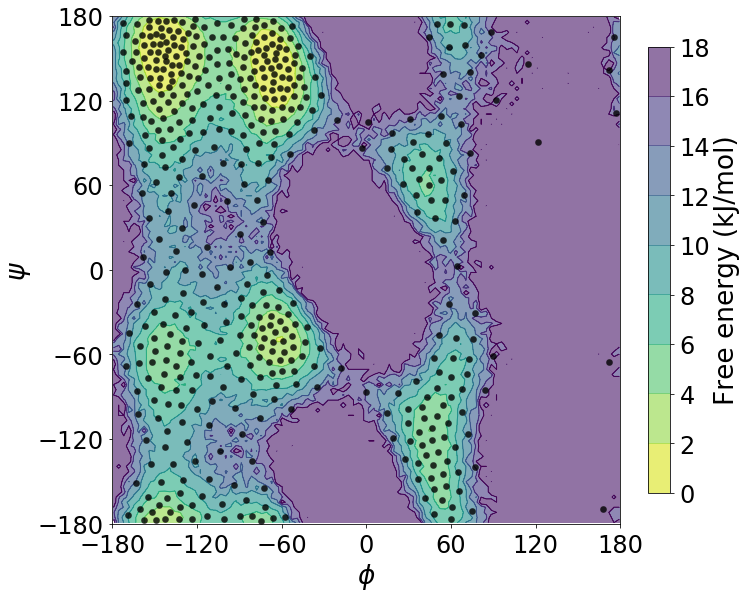

In [186]:
with sns.plotting_context('paper', font_scale=3):
    
    fig, ax = plt.subplots(1, figsize=(10,10))
    fig, ax = plot_free_energy(fxx[:,0]*units, fxx[:,1]*units, cmap='viridis_r', 
                               ncountours=10, hist_range=hist_range, vmax=None,kT=k*T, 
                               minener_zero=True, ticker=MultipleLocator(base=2), alpha=0.6, linewidths=1, ax=ax)
    
    ax.scatter(clustering.clustercenters[:,0]*units,clustering.clustercenters[:,1]*units,c='k', s=40, marker='o', 
               alpha=0.8, zorder=2)
    ax.set(aspect=1)


    plt.ylabel(r'$\psi$')
    plt.xlabel(r'$\phi$')
    plt.xlim((-180,180))
    plt.ylim((-180,180))
    
#     t  = plt.text(0.9, 0.2, 'C',color='k',
#         verticalalignment='top', horizontalalignment='right',
#         transform=ax.transAxes, fontsize=50)
    
#     t.set_bbox(dict(facecolor='white', alpha=1, edgecolor='white'))
    
    ax.yaxis.set_major_locator(MultipleLocator(base=60,))
    ax.xaxis.set_major_locator(MultipleLocator(base=60,))
    
    plt.savefig('figures/free_energy_2d_center_no_veroni.pdf', bbox_inches='tight')

In [117]:
from matplotlib.colors import ListedColormap
# cmap = plt.cm.viridis_r
# my_cmap = cmap(np.arange(cmap.N))
# my_cmap[:,-1] = np.array([0.6]*cmap.N)#np.linspace(0, 1, cmap.N)
# my_cmap = ListedColormap(my_cmap)

cmap = plt.cm.Greys
my_bw_cmap = cmap(np.arange(cmap.N))
my_bw_cmap[:,-1] = np.linspace(0.5,1,cmap.N)
my_bw_cmap = ListedColormap(my_bw_cmap)


    

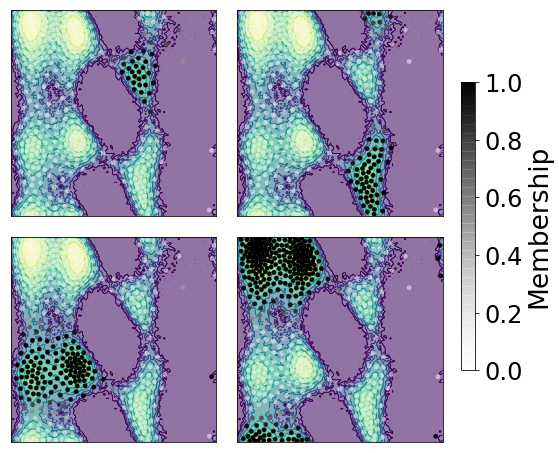

In [187]:
with sns.plotting_context('paper', font_scale=3):

    fig, axes = plt.subplots(2,2, figsize=(10,10))
    for state, ax in enumerate(axes.flatten()):
        
        fig, ax = plot_free_energy(fxx[:,0]*units, fxx[:,1]*units, cmap='viridis_r', 
                               ncountours=10, hist_range=hist_range, vmax=None,kT=k*T, 
                               minener_zero=True, ticker=MultipleLocator(base=2), alpha=0.6, linewidths=1,
                                   ax=ax, cbar=False)
        
        c = ax.scatter(clustering.clustercenters[:,0]*units, clustering.clustercenters[:, 1]*units, 
                       c=membership[:,state], 
                   cmap=my_bw_cmap, label='State {}'.format(state+1), s=20, zorder=2)

        ax.set(aspect=1)
        ax.set_xlim((-180,180))
        ax.set_ylim((-180,180))
        
        ax.tick_params(axis='both', which='both', bottom='off', top='off', left='off', labelbottom='off', labelleft='off')

#         t  = plt.text(0.95, 0.2, 'D{}'.format(state+1),color='k',
#             verticalalignment='top', horizontalalignment='right',
#             transform=ax.transAxes,fontsize=25)
#         t.set_bbox(dict(facecolor='white', alpha=1, edgecolor='white'))
        
        
    cbar_ax = fig.add_axes([0.825, 0.3, 0.02, 0.4])
    fig.colorbar(c, cax=cbar_ax, label='Membership')

    
    
    plt.subplots_adjust(wspace=0.1, hspace=0.1, top=0.8, bottom=0.2, left=0.2, right=0.8)
    plt.savefig('figures/membership_all_states.pdf', bbox_inches='tight')

In [141]:
pi_per_state = [HMM.stationary_distribution_obs*np.round(membership[:,state]) for state in range(HMM.nstates)]

max_pi_per_state = [np.argmax(x) for x in pi_per_state]
pos = np.array([[clustering.clustercenters[max_pi_per_state[state],0]*units, 
        clustering.clustercenters[max_pi_per_state[state],1]*units] for state in range(HMM.nstates) ])
pos[3][0] -= 40
pos[3][1] -= 10
pos[2][0] -= 40
pos[2][1] -= 10
pos

array([[  44.29485252,   59.92308008],
       [  46.51425078, -112.49461582],
       [ -99.20883354,  -60.7778905 ],
       [-112.57877174,  126.37980784]])

In [142]:
labels = np.array2string(HMM.P, formatter={'float_kind':lambda x: "{:.2f}%".format(x*100)})
labels = np.array([['{:.2f}%'.format(HMM.P[i,j]*100) for i in range(HMM.nstates)] for j in range(HMM.nstates)])
labels

array([['91.34%', '0.91%', '0.00%', '0.01%'],
       ['1.86%', '97.17%', '0.06%', '0.00%'],
       ['0.00%', '1.90%', '97.05%', '0.37%'],
       ['6.80%', '0.02%', '2.89%', '99.61%']], 
      dtype='<U6')

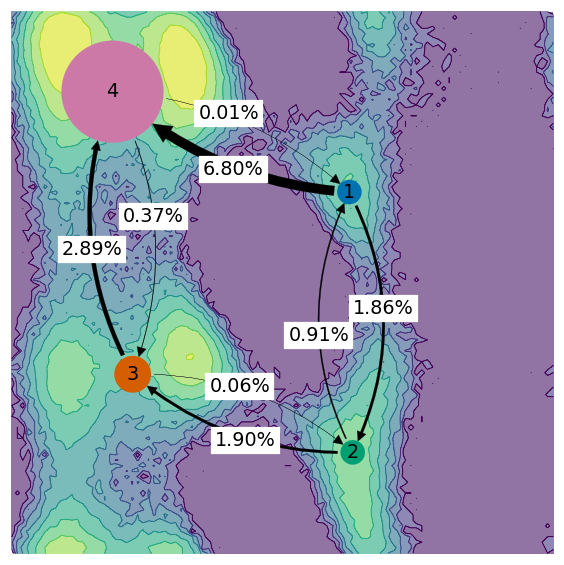

In [183]:

with sns.plotting_context('paper', font_scale=2):
    
    state_colors = sns.color_palette('colorblind', HMM.nstates)
    state_sizes = np.array([np.max([5e-2,x]) for x in HMM.stationary_distribution])

    fig, axes = plt.subplots(1, figsize=(10,10))   
    
#     t  = plt.text(0.95, 0.2, 'B',color='k',
#         verticalalignment='top', horizontalalignment='right',
#         transform=axes.transAxes,fontsize=50)
#     t.set_bbox(dict(facecolor='white', alpha=1, edgecolor='white'))
    
    axes.tick_params(axis='both', which='both', bottom='off', 
                       top='off', left='off', labelbottom='off', labelleft='off')

    
    fig, axes = plot_free_energy(fxx[:,0]*units, fxx[:,1]*units, cmap='viridis_r', 
                           ncountours=10, hist_range=hist_range, vmax=None,kT=k*T, 
                           minener_zero=True, ticker=MultipleLocator(base=2), alpha=0.6, linewidths=1,
                               ax=axes, cbar=False)
    
    plot_markov_model(HMM,pos=pos, minflux=1e-5, arrow_label_format='', arrow_labels=labels.T, ax=axes, 
                           state_scale=2, arrow_curvature=2.0, state_colors=state_colors, 
                     state_sizes=state_sizes, state_labels=np.arange(1,5))
    

    axes.set(aspect=1)

    plt.xlim((-180,180))
    plt.ylim((-180,180))
    plt.savefig('figures/hmm_overlay.pdf',bbox_inches='tight')

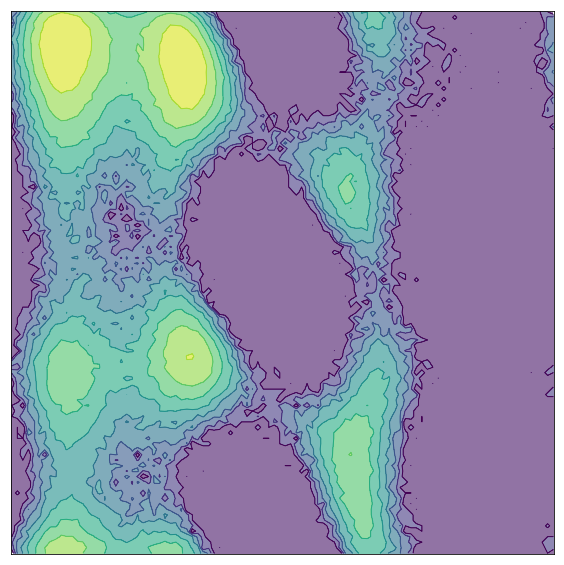

In [184]:

with sns.plotting_context('paper', font_scale=2):    

    fig, axes = plt.subplots(1, figsize=(10,10))    
    axes.tick_params(axis='both', which='both', bottom='off', 
                       top='off', left='off', labelbottom='off', labelleft='off')
    
    hist_range=[[-181,181],[-181,181]]
    fig, axes = plot_free_energy(fxx[:,0]*units, fxx[:,1]*units, cmap='viridis_r', 
                           ncountours=10, hist_range=hist_range, vmax=None,kT=k*T, 
                           minener_zero=True, ticker=MultipleLocator(base=2), alpha=0.6, linewidths=1,
                               ax=axes, cbar=False)

#     t  = plt.text(0.95, 0.2, 'A',color='k',
#         verticalalignment='top', horizontalalignment='right',
#         transform=axes.transAxes,fontsize=50)
#     t.set_bbox(dict(facecolor='white', alpha=1, edgecolor='white'))
    
    axes.set(aspect=1)
    plt.xlim((-180,180))
    plt.ylim((-180,180))
    plt.savefig('figures/free_energy_10x10.pdf',bbox_inches='tight')

In [ ]:
from scipy.spatial import Voronoi, voronoi_plot_2d
with sns.plotting_context('paper', font_scale=1.5):
    points = clustering.clustercenters*180/np.pi
    
    vor = Voronoi(points)
    

    units = 180/np.pi
    
    hist_range=[[-181,181],[-181,181]]
    
    fig, ax = plot_free_energy(fxx[:,0]*units, fxx[:,1]*units, cmap='viridis_r', 
                               ncountours=20, hist_range=hist_range, minener_zero=True, ticker=MultipleLocator(base=1))
    voronoi_plot_2d(vor, show_points=False, show_vertices=False, ax=ax, line_colors='0.8')

    
    plt.ylabel(r'$\phi$')
    plt.xlabel(r'$\psi$')
    plt.xlim((-180,180))
    plt.ylim((-180,180))

    plt.gca().yaxis.set_major_locator(MultipleLocator(base=60,))
    plt.gca().xaxis.set_major_locator(MultipleLocator(base=60,))
    plt.savefig('figures/free_energy_2d_veroni.png', transparent=True)

In [ ]:
with sns.plotting_context('paper', font_scale=1.5):
    state = 3
    state_idx = np.where(assignment==state)[0]
    points = clustering.clustercenters*180/np.pi
    
    vor = Voronoi(points)
    
    hist_range=[[-181,181],[-181,181]]
    
    fig, ax = plot_free_energy(fxx[:,0]*units, fxx[:,1]*units, cmap='viridis_r', 
                               ncountours=20, hist_range=hist_range, minener_zero=True)
    voronoi_plot_2d(vor, show_points=False, show_vertices=False, ax=ax,line_colors='0.8')
    
#     ##
#     reg_idx = np.array([vor.point_region[i] for i in state_idx])
#     regions, vertices = voronoi_finite_polygons_2d(vor, idx=reg_idx)
#     for region in regions:
#         polygon = vertices[region]
#         plt.fill(*zip(*polygon), alpha=0.4)

    
    for i in state_idx:
        reg_idx = vor.point_region[i]
        region = vor.regions[reg_idx]
        if not -1 in region:
            polygon = [vor.vertices[j] for j in region]
            ax.fill(*zip(*polygon), c='1', alpha=0.4)
            
    plt.ylabel(r'$\phi$')
    plt.xlabel(r'$\psi$')
    plt.xlim((-180,180))
    plt.ylim((-180,180))

    plt.gca().yaxis.set_major_locator(MultipleLocator(base=60,))
    plt.gca().xaxis.set_major_locator(MultipleLocator(base=60,))
    plt.tight_layout()
    plt.savefig('figures/free_energy_2d_veroni_state{}.png'.format(state+1), transparent=True)